## IRWA Final Project

#### Load Python packages
Let's first import all the packages that we will need during the project.

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from collections import defaultdict
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import math
import numpy as np
import collections
from numpy import linalg as la
import time
import pandas as pd
import re
from collections import Counter
import statistics
import json
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

### Part 1: Text Processing and Exploratory Data Analysis

#### Load data into memory

**Data:** You are provided with a document corpus which is a set of tweets related to the Farmers
Protests 2021. We also have the tweet_document_ids_map.csv that map Tweet IDs to Document IDs.

In [ ]:
#data_path = '/content/drive/MyDrive/IRWA/PROJECT I/content/drive/MyDrive/PROJECT IRWA/IRWA Project summary and first deliverable/'
#data_path = 'IRWA Project summary and first deliverable/data/' # locally
#data_path = '/content/drive/MyDrive/IRWA/PROJECT IRWA/IRWA Project summary and first deliverable/'
#data_path = '/content/drive/MyDrive/UPF/4t CURS/Recuperació de la Informació i Anàlisi de Web/PROJECT IRWA/IRWA Project summary and first deliverable/data/'

In [15]:
with open('/content/drive/MyDrive/PROJECT IRWA/IRWA Project summary and first deliverable/data/farmers-protest-tweets.json') as fp:
    tweets = fp.readlines()
tweets = [t.strip().replace(' +', ' ') for t in tweets]

In [16]:
tweet_document_ids_map = pd.read_csv('/content/drive/MyDrive/PROJECT IRWA/IRWA Project summary and first deliverable/data/tweet_document_ids_map.csv')

**1. Pre-process the documents.**
- Removing stop words
- Tokenization
- Removing punctuation marks - FALTA
- Stemming
- and... anything else you think it's needed (bonus point)

Revisar:
- Que fer amb els hastags, a part de guardar-los separats, si s'han de borrar del Tweet.
- @ - igual, s'han de borrar del Tweet?
- Les pàgines a que s'inclouen en els Tweets, exemple: https://t.co/es3kn0IQAF, s'ha de 'netejar'?
- S'ha de processar el content o el renderedContent?
- Amb quin tipus de dades ho hem de fer? cal guardar-ho en un pandas?
- què amb els tweets que no estan en anglès?

In [17]:
def process_tweet(tweet):

    # define the stemmer
    stemmer = PorterStemmer()

    # define the stopwords
    stop_words = set(stopwords.words("english"))

    # transform the line to lowercase
    tweet =  tweet.lower()

    # remove newline characters
    tweet = tweet.replace('\\n', '')

    # remove extra whitespaces
    tweet = ' '.join(tweet.split())

    # delete URLs on the tweet because we won't be able to access to them
    tweet = re.sub(r'\S*https?:\S*', '', tweet)

    # remove spaces at first and at the end of a message
    tweet.strip()

    # remove word that is with the hastag - hastag is saved separately
    tweet = re.sub(r' ?#\S+', '', tweet)

    # remove punctuation
    tweet = re.sub(r'[^a-z0-9#@ ]+', '', tweet)

    # delete punctuation
    tweet = re.sub(r'[^\w\s]', '', tweet)

    # tokenize the text to get a list of terms
    tweet = tweet.split()

    # eliminate the stopwords
    tweet = [word for word in tweet if word not in stop_words]

    # perform stemming
    tweet = [stemmer.stem(word) for word in tweet]

    return tweet

In [18]:
# assuming 'tweets' is a list of tweets in JSON format
processed_tweets = []

# Iterate over tweets
for tweet in tweets:
    # Convert into dict in order to extract info
    tweet = json.loads(tweet)

    # Extract relevant information
    tweet_id = tweet['id']
    tweet_content = tweet['content']
    tweet_date = tweet['date']
    tweet_hashtags = re.findall(r'#\w+', tweet_content)
    tweet_hashtags_count = len(tweet_hashtags)
    tweet_likes = tweet['likeCount']
    tweet_retweets = tweet['retweetCount']
    tweet_url = tweet['url']

    # Process the content
    tweet_content = process_tweet(tweet_content)

    # Add the extracted data to the DataFrame
    tweet_info = {
        "Id": tweet_id,
        "Tweet": tweet_content,
        "Date": tweet_date,
        "Hashtags": tweet_hashtags,
        "Hashtags_count": tweet_hashtags_count,
        "Likes": tweet_likes,
        "Retweets": tweet_retweets,
        "Url": tweet_url
    }

    # add to the dict
    processed_tweets.append(tweet_info)

In [19]:
processed_tweets = pd.DataFrame(processed_tweets)

In [20]:
print('Example of the first processed tweets:\n')
processed_tweets.head(8)

Example of the first processed tweets:



,Id,Tweet,Date,Hashtags,Hashtags_count,Likes,Retweets,Url
0,1364506249291784198,"[world, progress, indian, polic, govt, still, ...",2021-02-24T09:23:35+00:00,"[#ModiDontSellFarmers, #FarmersProtest, #FreeN...",3,0,0,https://twitter.com/ArjunSinghPanam/status/136...
1,1364506237451313155,"[kisanektamorcha, farmer, constantli, distroy,...",2021-02-24T09:23:32+00:00,"[#FarmersProtest, #ModiIgnoringFarmersDeaths, ...",3,0,0,https://twitter.com/PrdeepNain/status/13645062...
2,1364506195453767680,[],2021-02-24T09:23:22+00:00,[#FarmersProtest],1,0,0,https://twitter.com/parmarmaninder/status/1364...
3,1364506167226032128,"[reallyswara, rohinisgh, watch, full, video]",2021-02-24T09:23:16+00:00,"[#farmersprotest, #NoFarmersNoFood]",2,0,0,https://twitter.com/anmoldhaliwal/status/13645...
4,1364506144002088963,[],2021-02-24T09:23:10+00:00,"[#KisanEktaMorcha, #FarmersProtest, #NoFarmers...",3,0,0,https://twitter.com/KotiaPreet/status/13645061...
5,1364506120497360896,"[jai, jwaan, jai, kissan]",2021-02-24T09:23:05+00:00,"[#FarmersProtest, #ModiIgnoringFarmersDeaths]",2,0,0,https://twitter.com/babli_708/status/136450612...
6,1364506076272496640,[],2021-02-24T09:22:54+00:00,[#FarmersProtest],1,0,0,https://twitter.com/Varinde17354019/status/136...
7,1364505995859423234,[],2021-02-24T09:22:35+00:00,"[#ModiDontSellFarmers, #FarmersProtest]",2,0,0,https://twitter.com/BitnamSingh/status/1364505...


In [21]:
tweet_document_ids_map.rename(columns={'id': 'Id'}, inplace=True)

In [22]:
processed_tweets = processed_tweets.merge(tweet_document_ids_map, on='Id', how='left')

**2. Exploratory Data Analysis.**

Word counting distribution, average sentence length, vocabulary size, ranking of tweets most retweeted, word clouds for the most frequent words, and entity recognition. Feel free to do the exploratory analysis and report your findings in the report.

2.1. Data set lenght and empty tweets.

In [23]:
print("Total number of processed tweets are: {}".format(len(processed_tweets)))

Total number of processed tweets are: 117407


In [24]:
# check for empty tweets
empty_tweet_count = processed_tweets['Tweet'].apply(lambda x: x == []).sum()
print("Total number of empty tweets after processing theme is: {}".format((empty_tweet_count)))

Total number of empty tweets after processing theme is: 39126


In [25]:
# delete rows where 'Tweet' column contains an empty list
processed_tweets = processed_tweets[processed_tweets['Tweet'].apply(lambda x: x != [])]


2.2. Word counting distribution.

In [32]:
# util function for our analysis
def extract_content(tweet):

    parts = tweet.split('|')

    if len(parts) > 1:
        # extract the content of the tweet and convert into a list
        words_string = parts[1].strip()
        words_list = eval(words_string)

    return words_list

In [27]:
word_count = Counter()

for index, row in processed_tweets.iterrows():
    tweet_content = row['Tweet']
    word_count.update(tweet_content)

# show the distribution
print("Word counting distribution by descending order - top 10:")
for word, count in word_count.most_common(10):
    print(f"{word}: {count}")

Word counting distribution by descending order - top 10:
farmer: 17015
india: 6840
support: 6716
protest: 5002
amp: 4406
right: 3630
peopl: 3532
modi: 3482
indian: 2982
bjp: 2825


2.3. Average sentence length

In [33]:
length_list = []

for index, row in processed_tweets.iterrows():
    tweet_content = row['Tweet']
    length_list.append(len(tweet_content))

In [34]:
mean = round(statistics.mean(length_list), 4)
median = round(statistics.median(length_list), 4)
variance = round(statistics.variance(length_list), 4)
std_dev = round(statistics.stdev(length_list), 4)


print('Mean:', mean)
print('Median:', median)
print('Variance:', variance)
print('Standard Deviation:', std_dev)

Mean: 8.912
Median: 6
Variance: 64.4733
Standard Deviation: 8.0295


2.3. Vocabulary size.

In [35]:
vocabulary = set()

for index, row in processed_tweets.iterrows():
    tweet_content = row['Tweet']
    vocabulary.update(tweet_content)

In [36]:
print("The vocabulary size is: {}".format(len(vocabulary)))

The vocabulary size is: 47517


2.4. ranking of most retweeted tweets.

In [37]:
print('Ranking of the top 10 retweeted tweets:\n')
processed_tweets[['Retweets', 'Tweet']].sort_values(by='Retweets', ascending=False).head(10)

Ranking of the top 10 retweeted tweets:



,Retweets,Tweet
111329,7723,[200]
7645,6164,"[there, happen, germani, german, govt, didnt, ..."
89780,4673,"[disha, ravi, 21yearold, climat, activist, arr..."
88911,3742,"[disha, ravi, broke, court, room, told, judg, ..."
111556,3332,"[farmer, sweet, yall, see, amandacerni, rihanna]"
64492,3230,"[india, target, young, women, silenc, dissent,..."
108072,3182,"[bollywood, betray, panjab, amp, farmer, india..."
84368,2495,"[pleas, get, phd, antibjp, antiindia, period]"
23348,2258,"[revolut, 225lac, peopl, barnala, mahar]"
89423,2208,"[wish, fli, delhi, border, look, tough, time, ..."


2.5. ranking of most liked tweets.

In [38]:
print('Ranking of the top 10 liked tweets:\n')
processed_tweets[['Likes', 'Tweet']].sort_values(by='Likes', ascending=False).head(10)

Ranking of the top 10 liked tweets:



,Likes,Tweet
7645,27888,"[there, happen, germani, german, govt, didnt, ..."
111329,25824,[200]
111556,17325,"[farmer, sweet, yall, see, amandacerni, rihanna]"
108072,12949,"[bollywood, betray, panjab, amp, farmer, india..."
89423,12273,"[wish, fli, delhi, border, look, tough, time, ..."
88911,10403,"[disha, ravi, broke, court, room, told, judg, ..."
84368,9780,"[pleas, get, phd, antibjp, antiindia, period]"
66018,9390,"[pm, trp]"
89780,8974,"[disha, ravi, 21yearold, climat, activist, arr..."
23348,7574,"[revolut, 225lac, peopl, barnala, mahar]"


2.6. WordCloud for the most frequent words.

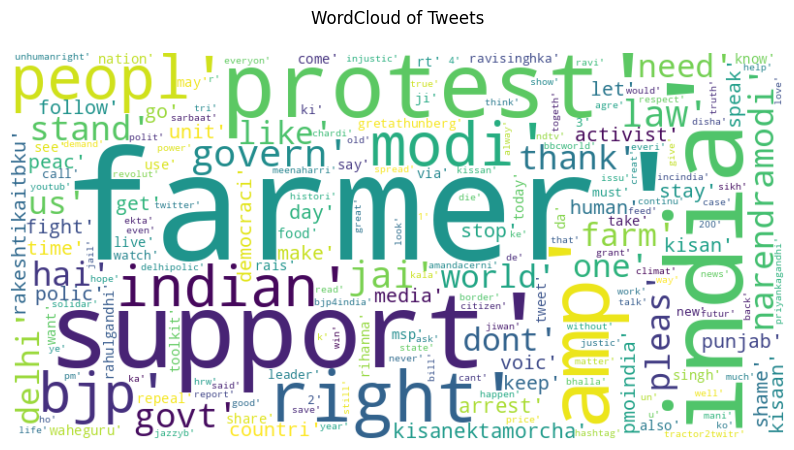

In [39]:
# check that are strings
all_tweets = ' '.join(processed_tweets['Tweet'].astype(str))

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    collocations=False
).generate(all_tweets)


plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of Tweets\n")
plt.show()


2.7. Correlation Matrix between Likes and Tweets.

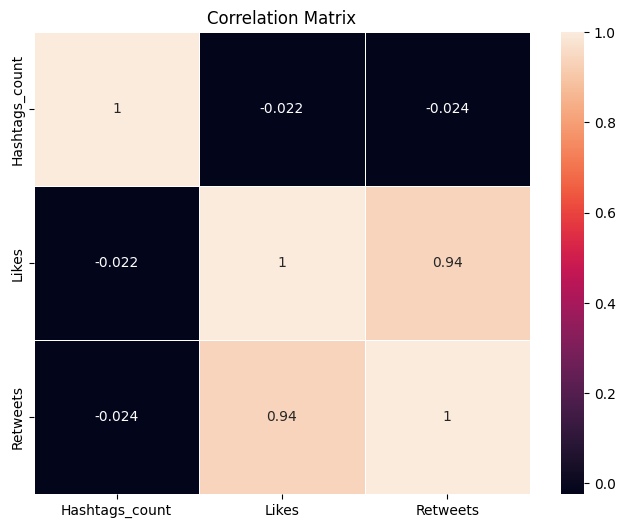

In [40]:
# Correlation Matrix

# exclude the id because is only the identifier
data_corr = processed_tweets.loc[:, processed_tweets.columns != 'Id'].corr(numeric_only=True)

plt.figure(figsize=(8, 6))
sns.heatmap(data_corr, annot=True, linewidths=.5)
plt.title("Correlation Matrix")
plt.show()